# Bad Apple!! 影絵 MV をスペクトログラムで見る


## ニコニコ動画から動画を取得する


`yt-dlp`を使って動画をダウンロードする。


In [1]:
!yt-dlp -o "sm8628149.mp4" https://www.nicovideo.jp/watch/sm8628149

[niconico] sm8628149: Downloading webpage
[niconico] sm8628149: Downloading video info page
[info] sm8628149: Downloading 1 format(s): h264_360p-aac_64kbps
[niconico_dmc] Downloading from DMC
[niconico] sm8628149: Downloading JSON metadata for h264_360p-aac_64kbps
[niconico] sm8628149: Acquiring permission for downloading video
[niconico_dmc] Heartbeat with 40 second interval ...
[download] Resuming download at byte 7321173
[download] Destination: sm8628149.mp4



In [2]:
!ls -l sm8628149.mp4 

.rw-r--r-- 19M hiroya  6 12 20:03  sm8628149.mp4


## 動画からフレームを取り出す


In [3]:
import cv2
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import hamming
import soundfile as sf
from tqdm.notebook import tqdm

In [4]:
VIDEO_PATH = "sm8628149.mp4"
FLAME_DIR = "frames"

In [5]:
if not os.path.exists(FLAME_DIR):
    os.mkdir(FLAME_DIR)

In [6]:
cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    raise Exception("Error opening video stream or file")
else:
    print("Video stream opened")

Video stream opened


In [7]:
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)

print(f"Video resolution: {frame_width}x{frame_height}")
print(f"Total frames: {frame_count}")
print(f"fps: {fps}")

Video resolution: 512x384
Total frames: 6573
fps: 30.0


In [8]:
num_of_digit = len(str(frame_count))

In [9]:
for i in tqdm(range(frame_count)):
    is_image, frame_img = cap.read()
    if is_image:
        # 0000.jpg ~ 6573.jpgのファイル名にする
        frame_path = os.path.join(VIDEO_PATH, str(i).zfill(num_of_digit) + ".jpg")
        cv2.imwrite(frame_path, frame_img)

  0%|          | 0/6573 [00:00<?, ?it/s]

In [10]:
cap.release()

## スペクトログラムに画像を埋め込む


In [11]:
SAMPLING_RATE = 22050

In [12]:
def img_to_wav(img: np.ndarray) -> np.ndarray:
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 画像の表示では原点は左上、スペクトログラムの表示では原点は左下なので合わせておく
    img_flip = cv2.flip(img_gray, 0)
    img_float = img_flip.astype(np.float32)

    # iSTFTでスペクトログラムから音声に変換
    wav_data = librosa.istft(img_float)
    return wav_data

In [13]:
def wav_to_spectrogram(
    wav_data: np.ndarray, n_fft=1024, hop_length=256, win_length=1024, window=hamming
) -> np.ndarray:
    wav_stft = librosa.stft(
        wav_data,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window=window,
    )
    spec, _ = librosa.magphase(wav_stft)
    spec_db = librosa.amplitude_to_db(spec)
    return spec_db

変換した様子を見てみる


Text(0.5, 1.0, 'Spectrogram')

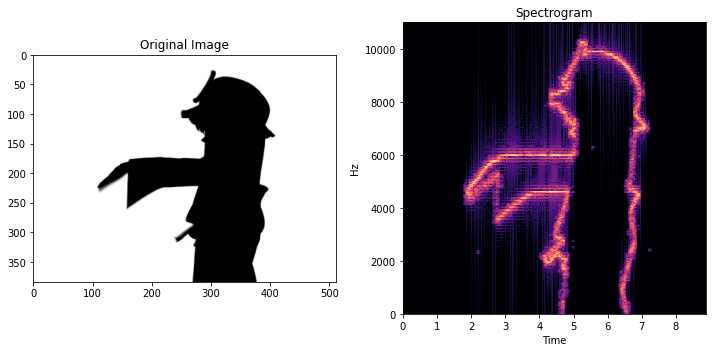

In [14]:
SAMPLE_IMG_PATH = "frames/1000.jpg"
img = cv2.imread(SAMPLE_IMG_PATH)
wav = img_to_wav(img)
spec_db = wav_to_spectrogram(wav)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
axs[0].imshow(img, cmap="gray")
axs[0].set_title("Original Image")
librosa.display.specshow(
    spec_db, sr=SAMPLING_RATE, x_axis="time", y_axis="linear", ax=axs[1], cmap="magma"
)
axs[1].set_title("Spectrogram")

In [16]:
PER_FRAME = 100
wav_unite = np.zeros(shape=(0,), dtype=np.float32)

# 各フレームを処理し、1つのwavデータにまとめる
for i in tqdm(range(0, frame_count, PER_FRAME)):
    img_path = os.path.join(FLAME_DIR, str(i).zfill(num_of_digit) + ".jpg")
    img = cv2.imread(img_path)
    wav = img_to_wav(img)
    wav_unite = np.concatenate((wav_unite, wav))

  0%|          | 0/66 [00:00<?, ?it/s]

In [17]:
# wavを書き出す
with sf.SoundFile("output.wav", mode="w", samplerate=SAMPLING_RATE, channels=1) as f:
    f.write(wav_unite)

## スペクトログラムを表示する


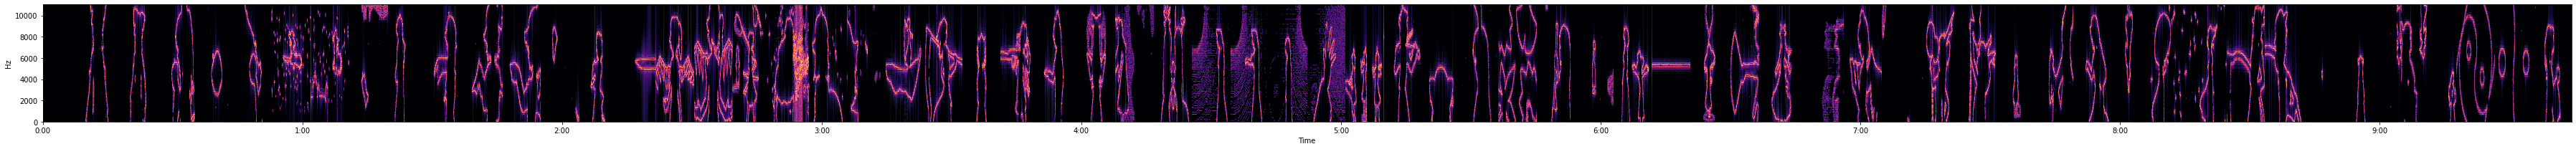

In [18]:
wav_data, sampling_rate = librosa.load("output.wav")
spec_db = wav_to_spectrogram(wav_data)

fig = plt.figure(figsize=(50, 3), tight_layout=True)
ax = fig.add_subplot(111)
librosa.display.specshow(
    spec_db, sr=SAMPLING_RATE, x_axis="time", y_axis="linear", ax=ax, cmap="magma"
)